# UNet Segmentation

Our goal will be to segment brain MRI images (Magnetic Resonance Imaging) to detect gray and white matter. The above using UNet architecture.

Import require packages

In [ ]:
import torch
import torch.nn.functional as F
import wandb
from tqdm import tqdm

Read data of Magnetic Resonance Imaging (MRIs).
This dataset can be donwloaded with execution of data_download.sh file.

In [1]:
import os
from pathlib import Path

path = Path('data/MRIs/')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

Visualization of one sample of Dataset.

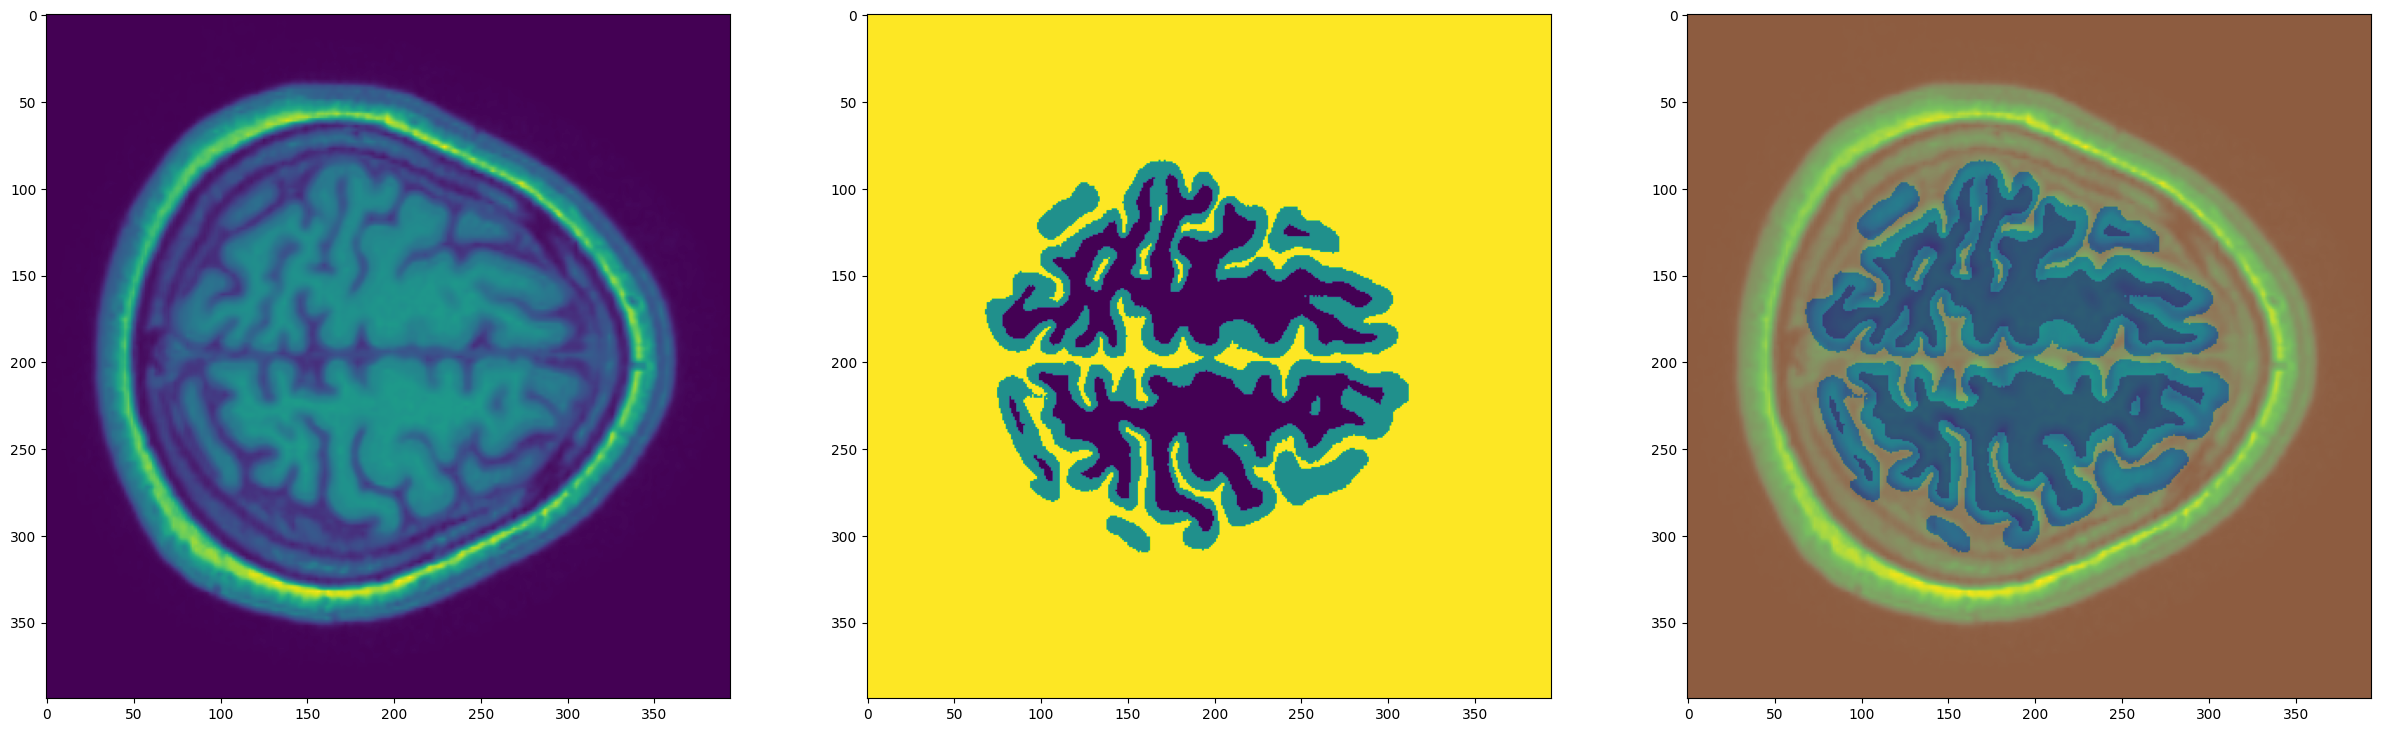

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Our images are 394 x 394 pixels, stored as NumPy arrays (which we can load with the np.load function). They are already normalized and in float32 format.

In [3]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.1462643, 0.00025629325)

As for the masks, we also have them saved as NumPy arrays. In this case the type is unit8, and the resolution is the same as the original image. In each pixel we can find three possible values: 0, 1 or 2. This value indicates the class (0 corresponds to white matter, 1 to gray matter, 2 to background).

In [4]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

When training our network we will need this mask in one-hot encoding format, in which we will extend each pixel in a list of length equal to the number of classes (in this case 3) with values of 0 in all positions except the one that corresponds to the class, where we will put a 1.

In [5]:
mask_oh = (np.arange(3) == mask[..., None]).astype(np.float32)
mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

In [ ]:
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)
img_tensor.shape, mask_tensor.shape

Define architecture of UNet

In [7]:
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )


def enconder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co)
    )


class deconv(torch.nn.Module):
    def __init__(self, ci, co) -> None:
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [8]:
class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=1) -> None:
        super().__init__()
        self.in_ch = in_ch

    
        c = [16, 32, 64, 128]

        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(self.in_ch, c[0]),
            conv3x3_bn(c[0], c[0])
        )

        self.conv2 = enconder_conv(c[0], c[1])
        self.conv3 = enconder_conv(c[1], c[2])
        self.conv4 = enconder_conv(c[2], c[3])

        self.deconv1 = deconv(c[3], c[2])
        self.deconv2 = deconv(c[2], c[1])
        self.deconv3 = deconv(c[1], c[0])

        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)
    

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)

        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

Test with dummy data input

In [9]:
model = UNet()
output = model(torch.randn((10, 1, 394, 394)))
output.shape

torch.Size([10, 3, 394, 394])

Define Intersection over Union (IoU) metric.

In [10]:
def iou(outputs, labels):
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1):
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

Define Dataset class

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3) -> None:
        self.X = X
        self.y = y
        self.n_classes = n_classes

    
    def __len__(self):
        return len(self.X)

    
    def __getitem__(self, ix):
        img = np.load(self.X[ix])
        mask = np.load(self.y[ix])
        img = torch.tensor(img).unsqueeze(0)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)
        return img, torch.from_numpy(mask).permute(2,0,1)

In [13]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(325, 100)

Create dataloader

In [14]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 1, 394, 394]), torch.Size([16, 3, 394, 394]))

Define function callback for EarlyStopping

In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Define fit function

In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit(model, dataloader, epochs=100, lr=3e-4, patience=3, pretrained=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if pretrained:
        print("Load pretrained model checkpoint.pt")
        model.load_state_dict(torch.load('checkpoints/checkpoint.pt'))
    model.to(device)
    hist = {'loss': [], 'iou':[], 'test_loss': [], 'test_iou': []}
    early_stopping = EarlyStopping(patience=5, verbose=True, path='checkpoints/checkpoint.pt')
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            avg_train_loss = np.mean(train_loss)
            bar.set_description(f"loss {avg_train_loss:.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                avg_test_loss = np.mean(test_loss)
                bar.set_description(f"test_loss {avg_test_loss:.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        early_stopping(avg_test_loss, model)
        wandb.log({'training_loss': np.mean(train_loss), 'training_iou':np.mean(train_iou), 'test_loss': np.mean(test_loss), 'test_iou': np.mean(test_iou)})
        wandb.watch(model, log="all")
        output = y_hat[-1]
        pred_mask = torch.argmax(output, axis=0)
        mask_value = torch.argmax(masks[-1], axis=0)
        grid_images = torch.hstack([imgs[-1].squeeze(0), mask_value.squeeze(), pred_mask.squeeze()])
        images = wandb.Image(grid_images, caption="Image / Mask / Prediction")
        wandb.log({"examples": images})
        if early_stopping.early_stop:
            print("Early stopping Activated")
            break

    return hist

Initialize the experiment in Weight and Biases (W&B) and a simple config.

In [45]:
wandb.init(project="UNet_segmentation", entity="andresrestrepo")

wandb.config = {
  "epochs": 50
}

Initialize model and start training

In [46]:
model = UNet()
hist = fit(model, dataloader, epochs=wandb.config['epochs'], pretrained=False)

test_loss 0.66366 test_iou 0.12695: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]



Epoch 1/50 loss 0.54233 iou 0.28780 test_loss 0.66366 test_iou 0.12695
Validation loss decreased (inf --> 0.663662).  Saving model ...


test_loss 0.45540 test_iou 0.25468: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]



Epoch 2/50 loss 0.38447 iou 0.42990 test_loss 0.45540 test_iou 0.25468
Validation loss decreased (0.663662 --> 0.455398).  Saving model ...


test_loss 0.25719 test_iou 0.31694: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]



Epoch 3/50 loss 0.28986 iou 0.33354 test_loss 0.25719 test_iou 0.31694
Validation loss decreased (0.455398 --> 0.257193).  Saving model ...


test_loss 0.22080 test_iou 0.29418: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]



Epoch 4/50 loss 0.23411 iou 0.32120 test_loss 0.22080 test_iou 0.29418
Validation loss decreased (0.257193 --> 0.220795).  Saving model ...


test_loss 0.19388 test_iou 0.30240: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]



Epoch 5/50 loss 0.19971 iou 0.32597 test_loss 0.19388 test_iou 0.30240
Validation loss decreased (0.220795 --> 0.193877).  Saving model ...


test_loss 0.17877 test_iou 0.31546: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]



Epoch 6/50 loss 0.17585 iou 0.33902 test_loss 0.17877 test_iou 0.31546
Validation loss decreased (0.193877 --> 0.178768).  Saving model ...


test_loss 0.16229 test_iou 0.34916: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]



Epoch 7/50 loss 0.15824 iou 0.36098 test_loss 0.16229 test_iou 0.34916
Validation loss decreased (0.178768 --> 0.162295).  Saving model ...


test_loss 0.15355 test_iou 0.40665: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]



Epoch 8/50 loss 0.14606 iou 0.39120 test_loss 0.15355 test_iou 0.40665
Validation loss decreased (0.162295 --> 0.153550).  Saving model ...


test_loss 0.13946 test_iou 0.47278: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]



Epoch 9/50 loss 0.13559 iou 0.46765 test_loss 0.13946 test_iou 0.47278
Validation loss decreased (0.153550 --> 0.139455).  Saving model ...


test_loss 0.12990 test_iou 0.57670: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]



Epoch 10/50 loss 0.12659 iou 0.54500 test_loss 0.12990 test_iou 0.57670
Validation loss decreased (0.139455 --> 0.129901).  Saving model ...


test_loss 0.11865 test_iou 0.64081: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]



Epoch 11/50 loss 0.11714 iou 0.63408 test_loss 0.11865 test_iou 0.64081
Validation loss decreased (0.129901 --> 0.118650).  Saving model ...


test_loss 0.11032 test_iou 0.64672: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]



Epoch 12/50 loss 0.10719 iou 0.69419 test_loss 0.11032 test_iou 0.64672
Validation loss decreased (0.118650 --> 0.110322).  Saving model ...


test_loss 0.10664 test_iou 0.66152: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]



Epoch 13/50 loss 0.09871 iou 0.71668 test_loss 0.10664 test_iou 0.66152
Validation loss decreased (0.110322 --> 0.106635).  Saving model ...


test_loss 0.09521 test_iou 0.71082: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]



Epoch 14/50 loss 0.09192 iou 0.72866 test_loss 0.09521 test_iou 0.71082
Validation loss decreased (0.106635 --> 0.095206).  Saving model ...


test_loss 0.08878 test_iou 0.72369: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]



Epoch 15/50 loss 0.08670 iou 0.73431 test_loss 0.08878 test_iou 0.72369
Validation loss decreased (0.095206 --> 0.088783).  Saving model ...


test_loss 0.08680 test_iou 0.72557: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]



Epoch 16/50 loss 0.08167 iou 0.74503 test_loss 0.08680 test_iou 0.72557
Validation loss decreased (0.088783 --> 0.086796).  Saving model ...


test_loss 0.08420 test_iou 0.74299: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]



Epoch 17/50 loss 0.07825 iou 0.75037 test_loss 0.08420 test_iou 0.74299
Validation loss decreased (0.086796 --> 0.084197).  Saving model ...


test_loss 0.07699 test_iou 0.74281: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]



Epoch 18/50 loss 0.07609 iou 0.75027 test_loss 0.07699 test_iou 0.74281
Validation loss decreased (0.084197 --> 0.076990).  Saving model ...


test_loss 0.07672 test_iou 0.74190: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]



Epoch 19/50 loss 0.07228 iou 0.75846 test_loss 0.07672 test_iou 0.74190
Validation loss decreased (0.076990 --> 0.076722).  Saving model ...


test_loss 0.08156 test_iou 0.71037: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]



Epoch 20/50 loss 0.07016 iou 0.76139 test_loss 0.08156 test_iou 0.71037
EarlyStopping counter: 1 out of 5


test_loss 0.07482 test_iou 0.73732: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]



Epoch 21/50 loss 0.06825 iou 0.76412 test_loss 0.07482 test_iou 0.73732
Validation loss decreased (0.076722 --> 0.074823).  Saving model ...


test_loss 0.07361 test_iou 0.73899: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]



Epoch 22/50 loss 0.06736 iou 0.76285 test_loss 0.07361 test_iou 0.73899
Validation loss decreased (0.074823 --> 0.073614).  Saving model ...


test_loss 0.07004 test_iou 0.75376: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]



Epoch 23/50 loss 0.06342 iou 0.77369 test_loss 0.07004 test_iou 0.75376
Validation loss decreased (0.073614 --> 0.070044).  Saving model ...


test_loss 0.07218 test_iou 0.74111: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]



Epoch 24/50 loss 0.06177 iou 0.77835 test_loss 0.07218 test_iou 0.74111
EarlyStopping counter: 1 out of 5


test_loss 0.06965 test_iou 0.75263: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]



Epoch 25/50 loss 0.05981 iou 0.78298 test_loss 0.06965 test_iou 0.75263
Validation loss decreased (0.070044 --> 0.069653).  Saving model ...


test_loss 0.06905 test_iou 0.74856: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]



Epoch 26/50 loss 0.05800 iou 0.78681 test_loss 0.06905 test_iou 0.74856
Validation loss decreased (0.069653 --> 0.069051).  Saving model ...


test_loss 0.06553 test_iou 0.76055: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]



Epoch 27/50 loss 0.05707 iou 0.78787 test_loss 0.06553 test_iou 0.76055
Validation loss decreased (0.069051 --> 0.065527).  Saving model ...


test_loss 0.07014 test_iou 0.74344: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]



Epoch 28/50 loss 0.05649 iou 0.78864 test_loss 0.07014 test_iou 0.74344
EarlyStopping counter: 1 out of 5


test_loss 0.06671 test_iou 0.75378: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]



Epoch 29/50 loss 0.05501 iou 0.79324 test_loss 0.06671 test_iou 0.75378
EarlyStopping counter: 2 out of 5


test_loss 0.06525 test_iou 0.76192: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]



Epoch 30/50 loss 0.05407 iou 0.79597 test_loss 0.06525 test_iou 0.76192
Validation loss decreased (0.065527 --> 0.065254).  Saving model ...


test_loss 0.09131 test_iou 0.66171: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]



Epoch 31/50 loss 0.05434 iou 0.79230 test_loss 0.09131 test_iou 0.66171
EarlyStopping counter: 1 out of 5


test_loss 0.06430 test_iou 0.76111: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]



Epoch 32/50 loss 0.05509 iou 0.78733 test_loss 0.06430 test_iou 0.76111
Validation loss decreased (0.065254 --> 0.064302).  Saving model ...


test_loss 0.06366 test_iou 0.76793: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]



Epoch 33/50 loss 0.05051 iou 0.80515 test_loss 0.06366 test_iou 0.76793
Validation loss decreased (0.064302 --> 0.063663).  Saving model ...


test_loss 0.06171 test_iou 0.77024: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]



Epoch 34/50 loss 0.04912 iou 0.80894 test_loss 0.06171 test_iou 0.77024
Validation loss decreased (0.063663 --> 0.061708).  Saving model ...


test_loss 0.06304 test_iou 0.76220: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]



Epoch 35/50 loss 0.04822 iou 0.81099 test_loss 0.06304 test_iou 0.76220
EarlyStopping counter: 1 out of 5


test_loss 0.06652 test_iou 0.75377: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]



Epoch 36/50 loss 0.04724 iou 0.81459 test_loss 0.06652 test_iou 0.75377
EarlyStopping counter: 2 out of 5


test_loss 0.06358 test_iou 0.75738: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]



Epoch 37/50 loss 0.04703 iou 0.81486 test_loss 0.06358 test_iou 0.75738
EarlyStopping counter: 3 out of 5


test_loss 0.06411 test_iou 0.75899: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]



Epoch 38/50 loss 0.04574 iou 0.81786 test_loss 0.06411 test_iou 0.75899
EarlyStopping counter: 4 out of 5


test_loss 0.06380 test_iou 0.76054: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]


Epoch 39/50 loss 0.04524 iou 0.82054 test_loss 0.06380 test_iou 0.76054
EarlyStopping counter: 5 out of 5
Early stopping Activated


Load checkpoint and test one single image.

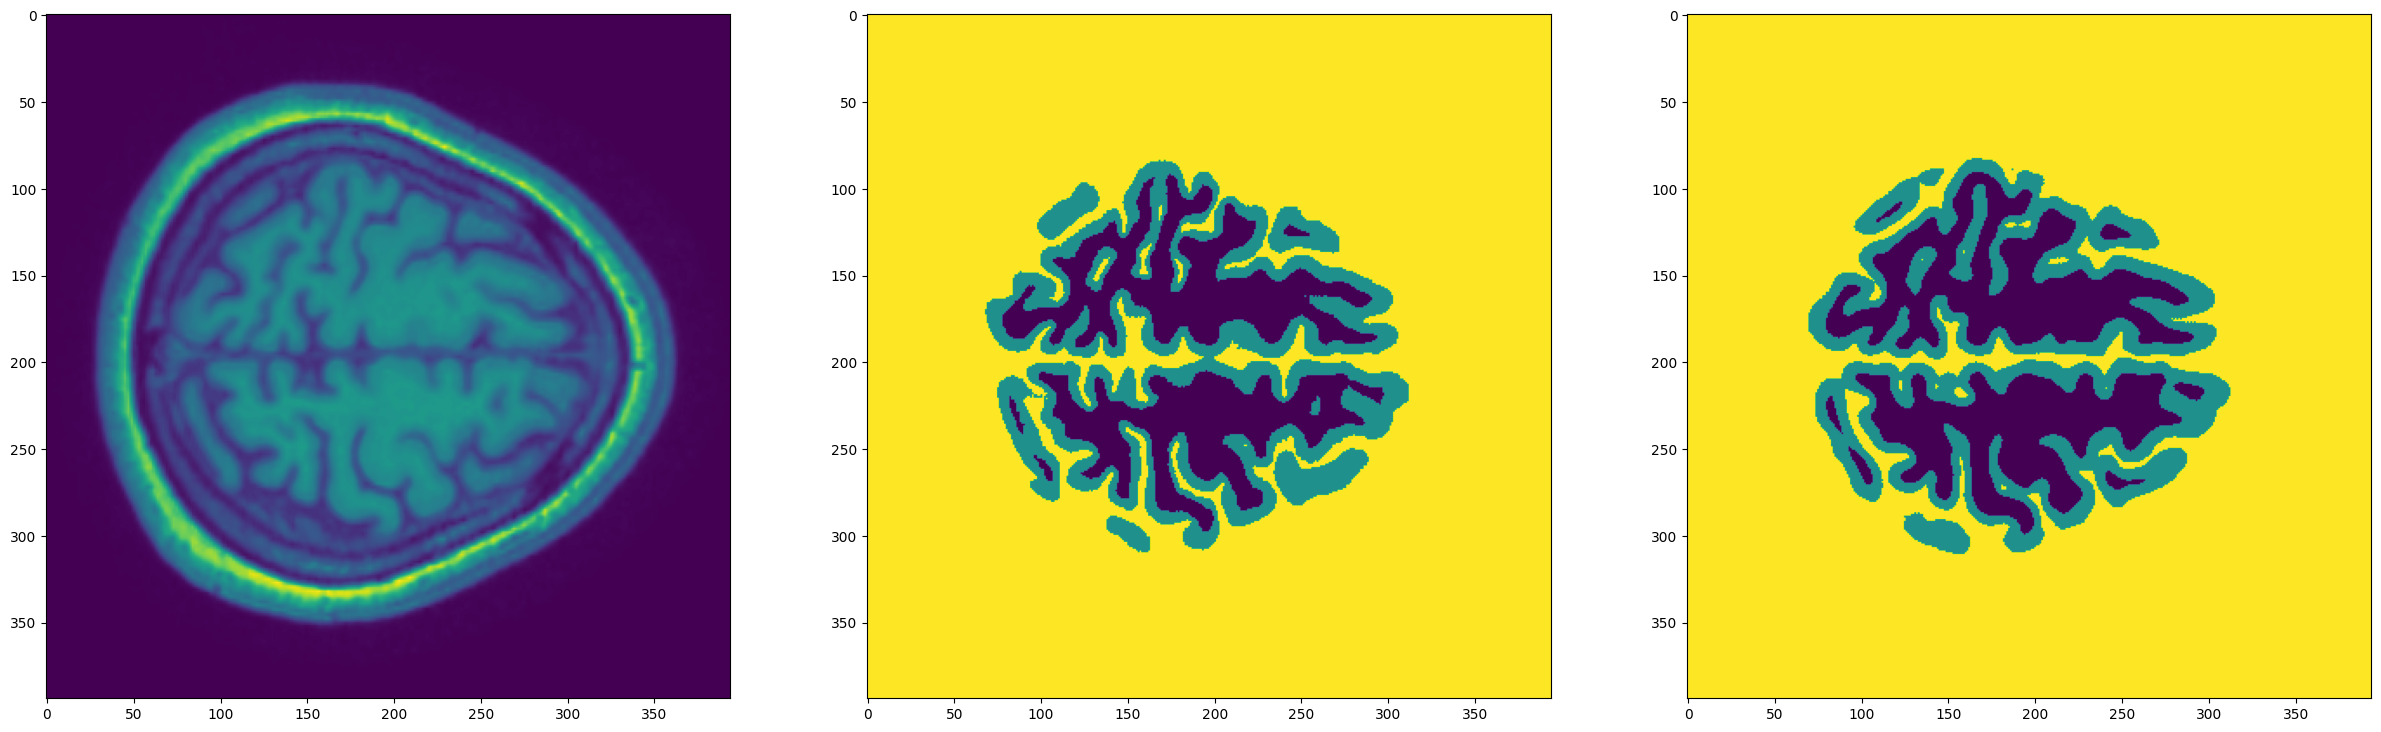

In [39]:

model = UNet()
model.load_state_dict(torch.load('checkpoints/checkpoint.pt'))
model.to(device)
model.eval()

with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()